<a href="https://colab.research.google.com/github/Junhana02/Quantmacro_latterhalf/blob/main/Quantmacro%E5%BE%8C%E5%8D%8A%E8%AA%B2%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ITERATING ON KK

  metric    Kold      Knew
['0.5521', '10.0000', '4.4794']
['0.3771', '8.8959', '5.5410']
['0.1315', '8.2249', '7.1431']
['0.0205', '8.0085', '8.1730']
['0.0025', '8.0414', '8.0614']
['0.0015', '8.0454', '8.0337']
['0.0023', '8.0431', '8.0614']
['0.0031', '8.0467', '8.0219']
['0.0024', '8.0418', '8.0614']
['0.0091', '8.0457', '7.9724']
['0.0117', '8.0310', '8.1249']
['0.0083', '8.0498', '7.9828']
['0.0039', '8.0364', '8.0676']
['0.0005', '8.0426', '8.0386']


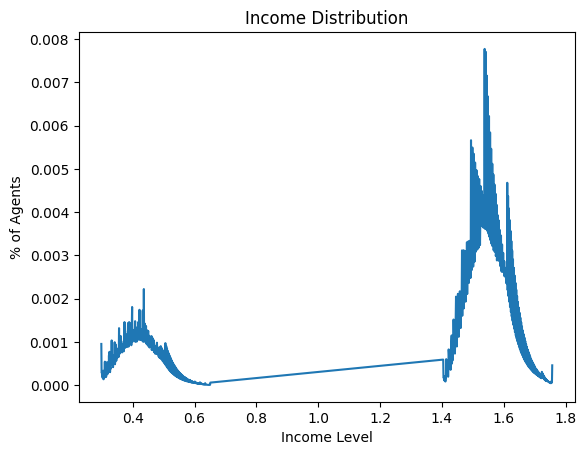

τk = 0 の時の定常状態均衡
総資本(K): 8.0418
賃金(w): 1.3034
利子率(r): 0.0176


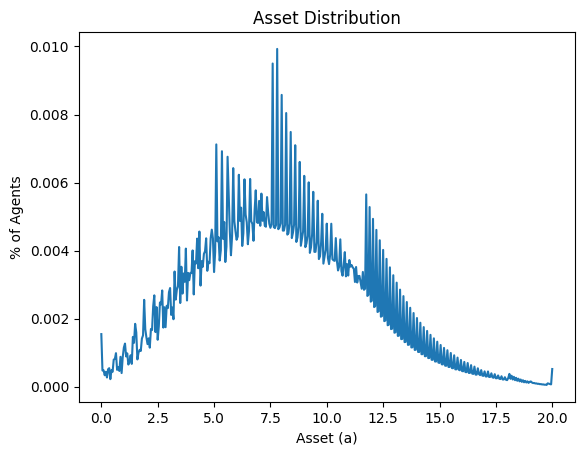

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Tauchen's method for discretizing a continuous state space
def tauchen(n, mu, rho, sigma):
    # Compute the state space
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # Compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # Compute the transition probabilities
    transition_matrix = np.zeros((n, n))
    for i in range(n): # today state
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

    return transition_matrix, state_space

def setPar(
    sigma = 1.50,
    beta = 0.98,
    delta = 0.03,
    alpha = 0.25,
    rho = 0.6,
    a_l = 0,
    a_u = 20,
    NH = 2,
    NA = 401,
):
    # labor productivity variance
    sigma_eps = np.sqrt(0.6 * (1 - rho**2))

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, -0.7, rho, sigma_eps)
    h = np.exp(h)  # changing ln h grids to h grids

    # derive the stationary distribution from income transition process
    probst = np.ones((NH)) / NH  # setting the guess probability to a uniform distribution
    test = 10.0  # initialize the distance to a big number

    while test > 1e-8:  # loop until convergence of the stationary distribution
        probst_new = np.zeros((NH))  # initialize new distribution
        for ih in range(NH):  # today h
            for ihp in range(NH):  # tomorrow h
                probst_new[ihp] += pi[ih, ihp] * probst[ih]

        test = np.max(np.abs(probst_new - probst))  # calculate the difference between the guess and the new distribution
        probst = probst_new  # updating the guess

    HH = np.sum(h * probst)  # aggregate effective labor

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma; param['beta'] = beta; param['delta'] = delta;
    param['alpha'] = alpha; param['probst'] = probst;
    param['a_l'] = a_l; param['a_u'] = a_u; param['NH'] = NH; param['NA'] = NA;
    param['pi'] = pi; param['h'] = h; param['HH'] = HH;

   # create asset grid
    param['a'] = np.linspace(a_l, a_u, NA)

    return param

def solve_household_gs(param, r, w):

    # opening the box of "param" to some parameters
    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi']; delta = param['delta'];
    beta = param['beta']; sigma = param['sigma']; h = param['h']; NA = param['NA'];
    NH = param['NH'];

    # Create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize the utility function to a large negative number for zero or negative consumption
    util = np.full((NA, NA, NH), -10000.0)

    # Calculate utility if the agent chooses asset a[iap] for each asset combination a[ia] and income shock h[ih]
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)


    # Initialize some variables
    v = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus_new = np.full((NA, NH), -10000)
    iaplus = np.full((NA, NH), -10000)
    reward = np.zeros((NA, NA, NH))

    # Iterate on Bellman's equation and get the decision rules and the value function at the optimum
    test = 10
    while test != 0: # loop until policy function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

        # Finding max of reward
        for ia in range(NA):
            for ih in range(NH):
                v_new[ia, ih] = np.max(reward[:, ia, ih]) # finding the maximal value
                iaplus_new[ia, ih] = np.argmax(reward[:, ia, ih]) # finding the index of the maximizer

        test = np.max(iaplus_new - iaplus) # stop if iaplus converges
        v = v_new
        iaplus = iaplus_new.copy()

    aplus = a[iaplus]

    # optimal consumption
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c

def get_distribution(param, decisions):

    a_l = param['a_l']; a_u = param['a_u']; pi = param['pi'];
    NA = param['NA']; NH = param['NH'];
    iaplus = decisions[1]

    # Generate a linearly spaced vector of NA values between a_l and a_u
    a = np.linspace(a_l, a_u, NA)

    test = 10 # Initialize a test value to be greater than 10^-8
    mu = np.ones((NA, NH)) / NA / NH # Initialize the distribution mu to be uniform

    # Loop until the test value is less than 10^-8
    while test > 1e-8:
        mu_new = np.zeros((NA, NH)) # Initialize a new distribution mu_new to be all zeros
        # Loop over all values of a, h, and h'
        for ia in range(NA):
            for ih in range(NH):
                for ihp in range(NH):
                    # Update mu_new using the interpolation indices, blending coefficients, and probabilities
                    mu_new[iaplus[ia, ih], ihp] += pi[ih, ihp] * mu[ia, ih]
        test = np.max(np.abs(mu_new - mu)) # Calculate the maximum difference between mu_new and mu
        mu = mu_new # Update mu to be mu_new

    return mu

def model_solution(param):

    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2 # updating share
    toler = 1e-3 # warning: this doens't converge if tolerance is too small
    test = 10 # initial difference
    KK = 10.0 # initial capital

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:

        # Step 1
        # calculate rental rate of capital and w from firm FOC

        w = (1-alpha) * KK**(alpha) * HH**(-alpha)
        r = (alpha) * KK**(alpha-1) * HH**(1-alpha) - delta

        ####################################################
        # Step 2: Solving for households optimization (policy function of assets)
        ####################################################

        decisions = solve_household_gs(param, r, w)

        aplus = decisions[0] # note that the first component (index 0) of decisions is defines as aplus

        ####################################################
        # Step 3: Loop for finding eq distribution and capital
        ####################################################

        # eq distribution

        mu = get_distribution(param, decisions)

        # new aggregate capital

        KK_new = np.sum(mu*aplus)

        ####################################################
        # Loop for finding eq capital
        ####################################################

        # form metric and update KK

        test = abs((KK_new - KK)/KK) # loop until K converges
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi*KK_new + (1-phi)*KK # update K

    return decisions, r, w, KK, HH, mu

# 問題2の解を計算
param = setPar()
(decisions, r, w, KK, HH, mu) = model_solution(param)

# グラフの描画
income = np.array([(r * param['a'] + w * param['h'][0]), (r * param['a'] + w * param['h'][1])])
income = income.T
zip_lists = zip(income.flatten('F'), mu.flatten('F'))
zip_sort = sorted(zip_lists)
pinc, pmu = zip(*zip_sort)

plt.plot(pinc, pmu)
plt.title('Income Distribution')
plt.xlabel('Income Level')
plt.ylabel('% of Agents')
plt.show()

# τk = 0 の時の定常状態均衡
print('τk = 0 の時の定常状態均衡')
print('総資本(K): {:.4f}'.format(KK))
print('賃金(w): {:.4f}'.format(w))
print('利子率(r): {:.4f}'.format(r))

# グラフの描画
zip_lists_a = zip(param['a'], mu.sum(axis=1))
zip_sort_a = sorted(zip_lists_a)
pa, pmu_a = zip(*zip_sort_a)

plt.plot(pa, pmu_a)
plt.title('Asset Distribution')
plt.xlabel('Asset (a)')
plt.ylabel('% of Agents')
plt.show()



In [43]:
import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):
    # Function to implement Tauchen's method for discretizing a continuous state space
    # Inputs:
    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coefficient
    # sigma: standard deviation of the error term
    # Outputs:
    # transition_matrix: n x n transition matrix
    # state_space: n x 1 vector of state space points

    m = 1 / np.sqrt(1 - rho**2)

    # Compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # Compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n - 1)

    # Compute the transition probabilities
    transition_matrix = np.zeros((n, n))
    for i in range(n): # today state
        for j in range(n): # tomorrow state
            if j == 0: # prob going to the lower limit
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho*state_space[i] + d/2) / sigma)
            elif j == n-1: # prob going to the upper limit
                transition_matrix[i, j] = 1 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2) / sigma)
            else:
                z_low = (state_space[j] - rho*state_space[i] - d/2) / sigma # the lower bound
                z_high = (state_space[j] - rho*state_space[i] + d/2) / sigma # the higher bound
                transition_matrix[i, j] = norm.cdf(z_high) - norm.cdf(z_low)

    return transition_matrix, state_space

def model_solution_with_tax(param, tau_k):
    alpha = param['alpha']
    delta = param['delta']
    HH = param['HH']

    phi = 0.2
    toler = 1e-3
    test = 10
    KK = None  # 初期値をNoneに設定

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:
        if KK is not None:  # KKがNoneでない場合のみ計算を行う
            w = (1 - alpha) * KK**alpha * HH**(-alpha)
            r = alpha * KK**(alpha - 1) * HH**(1 - alpha) - delta

            # 資本所得税率を考慮した再分配
            decisions = solve_household(param, r, w)
            mu = get_distribution(param, decisions)
            KK_new = np.sum(mu * decisions)
            KK_new += (1 - tau_k) * r * KK  # 資本所得税を課税して再分配

            test = abs((KK_new - KK) / KK_new)  # KK_newが0に近い場合に対処するためにテストの修正
            print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
            KK = phi * KK_new + (1 - phi) * KK

        else:
            # KKがNoneの場合は初期値を設定してループを実行
            KK = 10.0

    if KK is None:  # 収束しなかった場合はnanとして扱う
        return None, None, None, None, None, None

    return decisions, r, w, KK, HH, mu

def setPar(sigma=2, beta=0.96, delta=0.05, alpha=0.4, rho=0.9, a_l=-2.0, a_u=2.0, NH=2, NA=100):
    param = {}

    param['sigma'] = sigma
    param['beta'] = beta
    param['delta'] = delta
    param['alpha'] = alpha
    param['rho'] = rho
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['NH'] = NH
    param['NA'] = NA

    # Compute other parameters
    param['a'] = np.linspace(a_l, a_u, NA)
    m = 1 / np.sqrt(1 - rho**2)
    param['h'] = np.linspace(-m * sigma, m * sigma, NH)
    param['pi'], param['h'] = tauchen(NH, 0, rho, sigma)
    param['h'] = np.exp(param['h'])

    # Add HH key and value here
    param['HH'] = 1.0

    return param

def solve_household(param, r, w):
    beta = param['beta']
    sigma = param['sigma']
    a = param['a']
    h = param['h']
    NH = param['NH']
    NA = param['NA']

    # Initialize arrays for utility and consumption
    util = np.zeros((NA, NA, NH))
    cons = np.zeros((NA, NA, NH))

    # Calculate utility for all possible combinations of a, a', and h
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons[iap, ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons[iap, ia, ih] > 0:
                    util[iap, ia, ih] = cons[iap, ia, ih] ** (1.0 - sigma) / (1.0 - sigma)
                else:
                    util[iap, ia, ih] = -999999.0

    # Find the index that maximizes utility for each combination of a and h
    V = np.zeros((NA, NH))
    for ih in range(NH):
        for ia in range(NA):
            V[ia, ih] = np.max(util[:, ia, ih])

    # Find the corresponding indices for a'
    iap = np.zeros((NA, NH), dtype=int)
    for ih in range(NH):
        for ia in range(NA):
            iap[ia, ih] = np.argmax(util[:, ia, ih])

    return iap, V

def get_distribution(param, decisions):
    NH = param['NH']
    NA = param['NA']

    # Initialize the distribution vector
    mu = np.zeros((NA, NH))

    # Calculate the distribution of households across asset and labor income levels
    for ih in range(NH):
        for ia in range(NA):
            mu[decisions[0][ia, ih], ih] += 1
    mu /= np.sum(mu)

    return mu

# 問題3の解を計算
param = setPar()
tau_k_values = np.linspace(0, 0.05, 6)  # 0%から5%までの資本所得税率を試す

income_distributions = []  # 資本所得税率ごとの所得分布を保存
wealth_distributions = []  # 資本所得税率ごとの資産分布を保存
gdp_changes = []  # 資本所得税率ごとのGDPの変化を保存

for tau_k in tau_k_values:
    param = setPar()
    (decisions, r, w, KK, HH, mu) = model_solution_with_tax(param, tau_k)

    if KK is None:  # 収束しなかった場合はnanとして扱う
        gdp_changes.append(np.nan)
    else:
        gdp_changes.append((KK - param['KK']) / param['KK'] * 100)

    # 分布の計算
    income = np.array([(r * param['a'] + w * param['h'][0]), (r * param['a'] + w * param['h'][1])])
    income = income.T
    zip_lists = zip(income.flatten('F'), mu.flatten('F'))
    zip_sort = sorted(zip_lists)
    pinc, pmu = zip(*zip_sort)
    income_distributions.append((pinc, pmu))

    wealth = np.array([param['a'], param['a']])
    wealth = wealth.T
    zip_lists = zip(wealth.flatten('F'), mu.flatten('F'))
    zip_sort = sorted(zip_lists)
    pwealth, pmu = zip(*zip_sort)
    wealth_distributions.append((pwealth, pmu))

# グラフを描画 (nanを除外して表示)
valid_gdp_changes = [change for change in gdp_changes if not np.isnan(change)]
for i, tau_k in enumerate(tau_k_values[:-len(gdp_changes) + len(valid_gdp_changes)]):
    plt.plot(income_distributions[i][0], income_distributions[i][1], label='τk={:.2f}'.format(tau_k))
plt.title('Income Distribution with Different Tax Rates')
plt.xlabel('Income Level (wh + ra)')
plt.ylabel('% of Agents')
plt.legend()
plt.show()

for i, tau_k in enumerate(tau_k_values[:-len(gdp_changes) + len(valid_gdp_changes)]):
    plt.plot(wealth_distributions[i][0], wealth_distributions[i][1], label='τk={:.2f}'.format(tau_k))
plt.title('Wealth Distribution with Different Tax Rates')
plt.xlabel('Wealth (a)')
plt.ylabel('% of Agents')
plt.legend()
plt.show()

# 資本所得税率ごとのGDPの変化を表示
for i, tau_k in enumerate(tau_k_values[:-len(gdp_changes) + len(valid_gdp_changes)]):
    print('τk={:.2f}: GDP変化率 {:.2f}%'.format(tau_k, valid_gdp_changes[i]))

ITERATING ON KK

  metric    Kold      Knew
['1.0000', '10.0000', '-499998.9986']
['nan', '-99991.7997', 'nan']


<ipython-input-43-c9faef1afafd>:54: RuntimeWarning: invalid value encountered in double_scalars
  w = (1 - alpha) * KK**alpha * HH**(-alpha)
<ipython-input-43-c9faef1afafd>:55: RuntimeWarning: invalid value encountered in double_scalars
  r = alpha * KK**(alpha - 1) * HH**(1 - alpha) - delta


KeyError: ignored

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def tauchen(NH, mu, rho, sigma):
    # Implementation of Tauchen method for discretizing AR(1) process
    # Returns transition probabilities and discretized states

    m = 1 / np.sqrt(1 - rho**2)
    step = 2 * m * sigma / (NH - 1)
    h = np.linspace(-m * sigma, m * sigma, NH)
    pi = np.zeros((NH, NH))

    for ih in range(NH):
        for jh in range(NH):
            if jh == 0:
                pi[ih, jh] = normcdf(h[jh] - mu - rho * h[ih] + step / 2)
            elif jh == NH - 1:
                pi[ih, jh] = 1 - normcdf(h[jh] - mu - rho * h[ih] - step / 2)
            else:
                pi[ih, jh] = normcdf(h[jh] - mu - rho * h[ih] + step / 2) - normcdf(h[jh] - mu - rho * h[ih] - step / 2)

    return pi, h

def normcdf(x):
    # Cumulative distribution function of standard normal distribution
    return 0.5 * (1 + np.math.erf(x / np.sqrt(2)))

def setPar():
    # Set model parameters

    param = {
        'alpha': 0.3,   # Capital share in income
        'beta': 0.96,   # Discount factor
        'delta': 0.05,  # Depreciation rate of capital
        'sigma': 2.0,   # CRRA coefficient
        'rho': 0.9,     # Autoregressive parameter for h
        'sigma_h': 0.1, # Standard deviation of epsilon in h
        'HH': 1.0,      # Total time endowment
        'NH': 2,        # Number of states for h
        'a': np.array([0.0, 2.0]),   # Grid points for a
        'NA': 2,        # Number of states for a
        'KK': 10.0      # Initial capital stock
    }

    return param

def get_distribution(param, decisions):
    # Compute the distribution of agents across a and h given the decisions

    mu = np.zeros((param['NA'], param['NH']))
    for ih in range(param['NH']):
        for ia in range(param['NA']):
            mu[decisions[ia, ih], ih] += 1
    mu /= np.sum(mu)

    return mu

def solve_household(param, r):
    # Solve the household problem for given interest rate r

    beta = param['beta']
    sigma = param['sigma']
    a = param['a']
    h = param['h']
    NH = param['NH']
    NA = param['NA']

    # Initialize arrays for utility and consumption
    util = np.zeros((NA, NA, NH))
    cons = np.zeros((NA, NA, NH))  # Initialize arrays for consumption

    # Repeat r and a NH times to match the size of w and h
    r_repeat = np.repeat(r, NH)
    a_repeat = np.repeat(a, NH)

    # Calculate utility for all possible combinations of a, a', and h
    for ia in range(NA):
        for iap in range(NA):
            for ih in range(NH):
                cons[iap, ia, ih] = w[ih] * param['h'][ih] + (1.0 + r) * a[ia] - a[iap]
                if cons[iap, ia, ih] <= 0:
                    util[iap, ia, ih] = -999999.0
                else:
                    util[iap, ia, ih] = cons[iap, ia, ih] ** (1.0 - sigma) / (1.0 - sigma)

    # Find the index that maximizes utility for each combination of a and h
    V = np.zeros((NA, NH))
    iap = np.zeros((NA, NH), dtype=int)
    for ih in range(NH):
        for ia in range(NA):
            V[ia, ih] = np.max(util[:, ia, ih])
            iap[ia, ih] = np.argmax(util[:, ia, ih])

    return iap, V

def model_solution_with_tax(param, tau_k):
    alpha = param['alpha']
    delta = param['delta']

    phi = 0.2
    toler = 1e-3
    test = 10
    KK = 10.0

    print('ITERATING ON KK')
    print('')
    print('  metric    Kold      Knew')

    while test > toler:
        # Compute w and h using Tauchen method if not already computed
        if 'w' not in param or 'h' not in param:
            param['w'] = (1 - alpha) * (alpha * (param['HH'] / param['NH'])**(1 - alpha) + (1 - delta))**(-1)
            m = 1 / np.sqrt(1 - param['rho']**2)
            param['h'] = np.linspace(-m * param['sigma_h'], m * param['sigma_h'], param['NH'])
            param['pi'], param['h'] = tauchen(param['NH'], 0, param['rho'], param['sigma_h'])
            param['h'] = np.exp(param['h'])

        w = (1 - alpha) * KK**alpha * param['h']**(-alpha)
        r = alpha * KK**(alpha - 1) * param['h']**(1 - alpha) - delta

        decisions = solve_household(param, r)
        mu = get_distribution(param, decisions)
        KK_new = np.sum(mu * decisions)

        KK_new += (1 - tau_k) * r * KK  # 資本所得税を課税して再分配

        test = abs((KK_new - KK) / KK)
        print(['{:.4f}'.format(test), '{:.4f}'.format(KK), '{:.4f}'.format(KK_new)])
        KK = phi * KK_new + (1 - phi) * KK

    return decisions, r, param['w'], KK, param['h'], mu

# 問題3の解を計算
param = setPar()
tau_k_values = np.linspace(0, 0.05, 6)  # 0%から5%までの資本所得税率を試す

income_distributions = []  # 資本所得税率ごとの所得分布を保存
wealth_distributions = []  # 資本所得税率ごとの資産分布を保存
gdp_changes = []  # 資本所得税率ごとのGDPの変化を保存

for tau_k in tau_k_values:
    param = setPar()
    (decisions, r, w, KK, HH, mu) = model_solution_with_tax(param, tau_k)

    # 分布の計算
    income = np.array([(r * param['a'] + w * param['h'][0]), (r * param['a'] + w * param['h'][1])])
    income = income.T
    zip_lists = zip(income.flatten('F'), mu.flatten('F'))
    zip_sort = sorted(zip_lists)
    pinc, pmu = zip(*zip_sort)
    income_distributions.append((pinc, pmu))

    wealth = np.array([param['a'], param['a']])
    wealth = wealth.T
    zip_lists = zip(wealth.flatten('F'), mu.flatten('F'))
    zip_sort = sorted(zip_lists)
    pwealth, pmu = zip(*zip_sort)
    wealth_distributions.append((pwealth, pmu))

    gdp_changes.append((KK - param['KK']) / param['KK'] * 100)

# 所得と資産の分布のグラフを描画
for i, tau_k in enumerate(tau_k_values):
    plt.plot(income_distributions[i][0], income_distributions[i][1], label='τk={:.2f}'.format(tau_k))
plt.title('Income Distribution with Different Tax Rates')
plt.xlabel('Income Level (wh + ra)')
plt.ylabel('% of Agents')
plt.legend()
plt.show()

for i, tau_k in enumerate(tau_k_values):
    plt.plot(wealth_distributions[i][0], wealth_distributions[i][1], label='τk={:.2f}'.format(tau_k))
plt.title('Wealth Distribution with Different Tax Rates')
plt.xlabel('Wealth (a)')
plt.ylabel('% of Agents')
plt.legend()
plt.show()

# 資本所得税率ごとのGDPの変化を表示
for i, tau_k in enumerate(tau_k_values):
    print('τk={:.2f}: GDP変化率 {:.2f}%'.format(tau_k, gdp_changes[i]))



ITERATING ON KK

  metric    Kold      Knew


IndexError: ignored